In [2]:
import glob
from datetime import date

import pandas as pd

import altair as alt

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['svg.fonttype'] = 'none'

In [78]:
ministry_mapping = {
    'BBk': 'BBank',
    'BK Amt': 'BK',
    'BMELV': 'BMEL',
    'BMELVV': 'BMEL',
    'BMVBS': 'BMVI',
    'BPrA': 'BPräsA',
    'BMJ': 'BMJV',
    'BMJVV': 'BMJV',
    'BMVI': 'BMVBS',
    'BMU': 'BMUB',
}

def load_dataframe(filename):
    year = int(filename.split('_')[-1].split('.')[0])
    df = pd.read_csv(filename).fillna(0)
    df = df.rename(columns={'Ressort': 'name'})
    df = df[~df['name'].str.contains('Gesamt')]
    df['year'] = date(year, 1, 1)
    df['year'] = pd.to_datetime(df['year'])
    df['gb'] = df['name'].str.contains('GB')
    df['name'] = df['name'].str.replace(' GB', '')
    df['name'] = df['name'].str.replace('*', '', regex=True).str.replace('\d', '', regex=True).str.strip()
    for k, v in ministry_mapping.items():
        df['name'] = df['name'].str.replace('^' + k + '$', v, regex=True)
    df = df.rename(columns={k: k.strip().replace(' ', '_') for k in df.columns})
    
    # 2006 didn't have that
    if not 'sonstige_Erledigung' in df:
        df['sonstige_Erledigung'] = 0
    
    return df

In [105]:
filenames = glob.glob('data/ifg_statistik_*.csv')

required_columns = ["name", "year", "Eingang_Erstanträge", "Eingang_Klagen", "Informationszugang_gewährt",
                    "Informationszugang_teilweise_gewährt", "Informationszugang_abgelehnt",
                   "sonstige_Erledigung", "Gebühr_erhoben", "Eingang_Widersprüche"]
all_columns = []
dfs = []
errors = []

for filename in filenames:
    # load file
    df = load_dataframe(filename)
    dfs.append(df)
    
    # make sure our data isn't hot garbage
    columns = list(df.columns)
    for col in required_columns:
        if not col in columns:
            errors.append("{} missing in {}".format(col, df['year'][0].year))
    all_columns += columns

print('\n'.join(errors))
assert len(errors) == 0

df = pd.concat(dfs).filter(items=required_columns)
df.to_csv('ifg_statistik.csv', index=False)

In [106]:
df['name'].value_counts()

AA        30
BMF       30
BMAS      30
BMVg      30
BMG       30
BMWi      30
BMFSFJ    30
BMBF      30
BMEL      30
BMUB      30
BKM       30
BMJV      30
BMVBS     29
BK        29
BMI       29
BMZ       15
BPA       15
BPräsA    11
BfDI      10
BT        10
BBank     10
BRH        9
BR         9
BVerfG     6
Name: name, dtype: int64

## Eingang Erstanträge über die Jahre

(0.0, 58864.85)

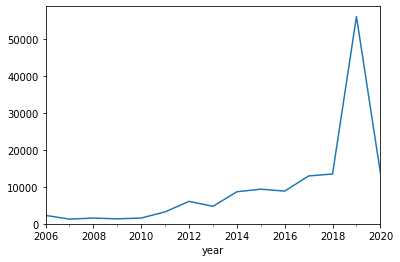

In [107]:
df.groupby('year')['Eingang_Erstanträge'].sum().plot()
plt.ylim(0)

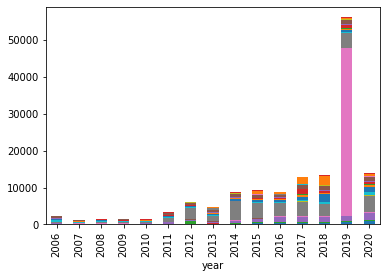

In [108]:
ax = df.groupby([df.year.dt.year, 'name'])['Eingang_Erstanträge'].sum().unstack().plot(kind='bar', stacked=True)
ax.legend().set_visible(False)

In [109]:
alt.Chart(df).mark_bar().encode(
    color='name',
    x='year',
    y='Eingang_Erstanträge',
    tooltip='name'
).interactive()

alt.Chart(...)

In [110]:
out_group = df.groupby(['name', 'year'])[required_columns].sum()

out_group['granted'] = out_group[['Informationszugang_gewährt', 'Informationszugang_teilweise_gewährt']].sum(1)
out_group['not_granted'] = out_group[['Informationszugang_abgelehnt', 'sonstige_Erledigung']].sum(1)
out_group['count'] = out_group['granted'] + out_group['not_granted']

out_group['transparency'] = out_group['granted'] / out_group['count'] * 100
out_group['transparency'] = out_group['transparency'].round()

out_group['filed_requests'] = out_group['Eingang_Erstanträge']


out_group = out_group.reset_index()

out_cols = ['name', 'year', 'granted', 'not_granted', 'count', 'transparency', 'filed_requests']
out_group = out_group.filter(items=out_cols)
out_group['year'] = pd.to_datetime(out_group['year']).dt.year
out_group.to_csv('data.csv', index=False)
out_group.head()

,name,year,granted,not_granted,count,transparency,filed_requests
0,AA,2006,81.0,37.0,118.0,69.0,131.0
1,AA,2007,56.0,28.0,84.0,67.0,88.0
2,AA,2008,94.0,32.0,126.0,75.0,132.0
3,AA,2009,98.0,35.0,133.0,74.0,139.0
4,AA,2010,102.0,46.0,148.0,69.0,158.0


## Anteil FdS